In [1]:
import torch
from torch import nn
from torch.autograd import grad,Variable
import torch.utils.data as Data
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torch import distributions

import abc
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


from collections import OrderedDict
from interpret.glassbox import ExplainableBoostingRegressor

In [2]:
%matplotlib notebook

In [27]:
class effectPloter():
    def __init__(self,model,X,is_numpy_model:bool):
        self.model = model
        self.is_numpy_model = is_numpy_model
        if self.is_numpy_model:
            self.X = X
        else:
            self.X = X.detach().cpu().numpy()
        self.N = X.shape[1]
    def get_main_effect(self,index,bins=256,is_cat=False):
        x_i = self.X[:,index]
        if is_cat:
            x_anchor = np.unique(x_i)
            bins = len(x_anchor)
        else:
            x_max, x_min = np.max(x_i), np.min(x_i)
            x_anchor = np.linspace(start=x_min, stop=x_max, num=bins)
        X_test_data = np.zeros((bins,self.N))
        X_test_data += np.mean(self.X,axis=0,keepdims=True)
        X_test_data[:,index] = x_anchor
        if self.is_numpy_model:
            y = self.model.predict(X_test_data)
            y -= np.mean(y)
            return x_anchor,y
        else:
            y = self.model(torch.from_numpy(X_test_data.astype('float32')))
            y -= torch.mean(y)
            return torch.from_numpy(x_anchor.astype('float32')),y
    def plot_main_effect(self,index,bins=256,is_cat=False):
        x_anchor,y = self.get_main_effect(index,bins,is_cat)
        if not self.is_numpy_model:
            x_anchor = x_anchor.detach().cpu().numpy()
            y = y.detach().cpu().numpy()
        plt.figure()
        plt.plot(x_anchor,y)
        plt.show()
        
    def get_interaction(self,index_i,index_j,bins=64,x_i_cat=False,x_j_cat=False,remove_mean=False):
        x_i = self.X[:,index_i]
        x_j = self.X[:,index_j]
        if x_i_cat:
            x_anchor_i = np.unique(x_i)
            M = len(x_anchor_i)
        else:
            x_max, x_min = np.max(x_i), np.min(x_i)
            x_anchor_i = np.linspace(start=x_min, stop=x_max, num=bins)
            M = bins
        if x_j_cat:
            x_anchor_j = np.unique(x_j)
            N = len(x_anchor_j)
        else:
            x_max, x_min = np.max(x_j), np.min(x_j)
            x_anchor_j = np.linspace(start=x_min, stop=x_max, num=bins)
            N = bins
        x_anchor_i,x_anchor_j = np.meshgrid(x_anchor_i,x_anchor_j)
        
        X_test_data = np.zeros((M*N,self.X.shape[1]))
        X_test_data += np.mean(self.X,axis=0,keepdims=True)
        X_test_data[:,index_i] = x_anchor_i.flatten()
        X_test_data[:,index_j] = x_anchor_j.flatten()
        if self.is_numpy_model:
            y = self.model.predict(X_test_data).reshape(N,M)
            if remove_mean:
                y = y - np.mean(y,axis=0).reshape(1,-1)
                y = y - np.mean(y,axis=1).reshape(-1,1)
            return x_anchor_i, x_anchor_j, y
        else:
            y = self.model(torch.from_numpy(X_test_data.astype('float32'))).view(N,M)
            if remove_mean:
                y = y - torch.mean(y,axis=0).reshape(1,-1)
                y = y - torch.mean(y,axis=1).reshape(-1,1)
            return torch.from_numpy(x_anchor_i.astype('float32')), torch.from_numpy(x_anchor_j.astype('float32')), y

    def plot_interaction(self,index_i,index_j,bins=64,x_i_cat=False,x_j_cat=False):
        x_anchor_i, x_anchor_j, y = self.get_interaction(index_i,index_j,bins,x_i_cat,x_j_cat,remove_mean=True)
        if not self.is_numpy_model:
            x_anchor_i = x_anchor_i.detach().cpu().numpy()
            x_anchor_j = x_anchor_j.detach().cpu().numpy()
            y = y.detach().cpu().numpy()
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.plot_surface(x_anchor_i, x_anchor_j, y, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
        ax.set_xlabel('f_'+str(index_i))
        ax.set_ylabel('f_'+str(index_j))
        ax.set_zlabel('y')
    def interaction_detection(self,K=None):
        interaction_strength = []
        for ii in range(self.N-1):
            for jj in range(ii+1,self.N):
                x_anchor_i,x_anchor_j,y = self.get_interaction(ii,jj,remove_mean=True)
                if self.is_numpy_model:
                    strength = np.sqrt(np.mean(np.mean(y**2,axis=-1),axis=-1))
                else:
                    strength = torch.sqrt(torch.mean(torch.mean(y**2,dim=-1),dim=-1)).item()
                    
                interaction_strength.append((ii,jj,strength))
        interaction_strength = sorted(interaction_strength, key=lambda x:-x[-1])
        if K is None:
            return interaction_strength
        else:
            return interaction_strength[:K]

### Construct NN

In [4]:
def generate_dataset_new(X,label):
    return torch.from_numpy(X), torch.from_numpy(label)

class res_block(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(res_block, self).__init__()
        self.linear_layer = nn.Linear(input_size, output_size)
        self.res_layer = nn.Linear(input_size, output_size)
        self.bn = nn.BatchNorm1d(output_size)

    def forward(self, x):
        x = F.relu(self.bn(self.linear_layer(x))) + self.res_layer(x)
        return x


class subNet(torch.nn.Module):
    def __init__(self, outputsize, layerSizeList):
        super(subNet, self).__init__()
        full_dim_list = [1]
        full_dim_list.extend(layerSizeList)
        full_dim_list.append(outputsize)
        blk_list = []
        for idx in range(len(full_dim_list)-1):
            res_blk = res_block(full_dim_list[idx],full_dim_list[idx+1])
            blk_list.append(res_blk)
        
        self.model = nn.Sequential(*blk_list)
        
    def forward(self, x):
        return self.model(x)

    
    
class GA2M(torch.nn.Module):
    def __init__(self, feature_num, layerSizeList, basis_num=128,interaction_list=None):
        super(GA2M, self).__init__()
        self.basis_num = basis_num
        self.feature_num=feature_num
        if interaction_list is None:
            self.permutation_num = int(self.feature_num*(self.feature_num-1)/2)
        else:
            self.permutation_num = len(interaction_list)
        self.interaction_map = self._generate_interaction_map(interaction_list)
        self.comb_layer = nn.Linear(self.permutation_num, 1)
        self.first_order_attention_weights = nn.Parameter(torch.zeros((1,self.feature_num,self.basis_num+1),requires_grad=True))
        self.second_order_attention_weights = nn.Parameter(torch.zeros((1,self.permutation_num,self.basis_num+1),requires_grad=True))
        self.netList = nn.ModuleList([subNet(outputsize=self.basis_num, layerSizeList=layerSizeList)
                                      for i in range(self.feature_num)])
        self.final_bn = nn.BatchNorm1d(self.feature_num)
    
    def _generate_interaction_map(self, interaction_list):
        if interaction_list is None:
            interaction_list = []
            for ii in range(self.feature_num-1):
                for jj in range(ii+1,self.feature_num):
                    interaction_list.append((ii,jj))
        interaction_list_permed = []
        for (ii,jj) in interaction_list:
            if np.random.randn(1) > 0:
                interaction_list_permed.append((ii,jj))
            else:
                interaction_list_permed.append((jj,ii))
        interaction_map = OrderedDict()
        for (ii,jj) in interaction_list_permed:
            if ii not in interaction_map.keys():
                interaction_map[ii] = [jj]
            else:
                interaction_map[ii].append(jj)
        return interaction_map

    def forward(self, x):
        latent = []
        for idx, subnet in enumerate(self.netList):
            latent.append(subnet(x[:, idx].unsqueeze(1)).unsqueeze(1))
        self.latent = torch.cat(latent, axis=1)
        self.latent = self.final_bn(self.latent)
            
        First_order_attention=F.softmax(self.first_order_attention_weights,dim=-1)
        main_effect = (self.latent)*First_order_attention[:,:,1:]
        x_main_effect = torch.mean(torch.sum(main_effect,axis=-1),dim=-1)

        Second_order_attention=F.softmax(self.second_order_attention_weights,dim=-1)
        x_interactions = 0
        attent_count = 0
        for idx, related_list in self.interaction_map.items():
            x_interactions += self.latent[:,idx,:]*torch.sum(Second_order_attention[:,attent_count:attent_count+len(related_list),1:]*self.latent[:,related_list,:],dim=1)
            attent_count += len(related_list)
        x_interactions = torch.sum(x_interactions,axis=-1)/self.permutation_num

        x_out = x_main_effect + x_interactions
        return x_out

        

### model train

In [5]:
def train(X_train,X_test,y_train,y_test,lambda_1=0.5,lr=0.01,batch_size=256,
            init_type='uniform',bn_type='unflatten'):
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

    N_train = X_train.shape[0]
    N_val = X_val.shape[0]
    N_test = X_test.shape[0]


    training_input, training_target = generate_dataset_new(X_train, y_train)
    val_input, val_target = generate_dataset_new(X_val, y_val)
    test_input, test_target = generate_dataset_new(X_test, y_test)

    torch_dataset_train = Data.TensorDataset(training_input, training_target)
    torch_dataset_val = Data.TensorDataset(val_input, val_target)
    torch_dataset_test = Data.TensorDataset(test_input, test_target)

    train_loader = Data.DataLoader(dataset=torch_dataset_train, batch_size=batch_size, shuffle=True)
    val_loader=Data.DataLoader(dataset=torch_dataset_val, batch_size=batch_size*100, shuffle=False)
    test_loader=Data.DataLoader(dataset=torch_dataset_test, batch_size=batch_size*100, shuffle=False)
    n_epochs = 50
    burn_in = 15
    model = GA2M(feature_num=X_train.shape[1],layerSizeList=[16,64],basis_num=128)
    optimizer =torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.99)
    model.train()
    lowest_val_loss = 1e+15
    report_test_loss = 1e+15
    paient = 0
    temperature = 1
    eps = 1
    for epoch in range(n_epochs):
        train_loss = 0.0
        eps = eps*0.9
        for step,(X_batch,target_batch) in enumerate(train_loader):
            X_batch.requires_grad_()
            y_hat = model(X_batch)
            fit_loss = torch.mean((target_batch.flatten() - y_hat.flatten()) ** 2)
            reg_1 = torch.mean(torch.mean(torch.mean(model.latent**2,dim=-1),dim=-1),dim=-1)
            reg_2 = torch.mean(torch.log(torch.sum(F.softmax(model.first_order_attention_weights,dim=-1)[:,:,1:],dim=-1)+eps),dim=-1)
            reg_3 =  torch.mean(torch.log(torch.sum(F.softmax(model.second_order_attention_weights,dim=-1)[:,:,1:],dim=-1)+eps),dim=-1)
            loss = fit_loss + 1e-3*reg_1 + 2e-3*reg_2 + 1e-2*reg_3
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            train_loss += fit_loss.detach().cpu().numpy()*X_batch.shape[0]

        train_loss = train_loss / N_train

        model.eval()
        with torch.no_grad():
            epoch_val_loss = 0.0
            for step, (X_batch, y_batch) in enumerate(val_loader):
                output = model(X_batch)
                loss = torch.sum((output.flatten()- y_batch.flatten())**2)
                epoch_val_loss += loss.detach().cpu().numpy()
            val_loss = epoch_val_loss/N_val
            
            epoch_test_loss = 0.0
            for step, (X_batch, y_batch) in enumerate(test_loader):
                output = model(X_batch)
                loss = torch.sum((output.flatten()- y_batch.flatten())**2)
                epoch_test_loss += loss.detach().cpu().numpy()
                
            test_loss = epoch_test_loss/N_test
            if (val_loss < lowest_val_loss) and (epoch>burn_in):
                lowest_val_loss = val_loss
                report_test_loss = test_loss
                PATH = str(epoch)+ "_model.pt"
                output_path = PATH
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': lowest_val_loss,
                    }, PATH)
                paient = 0
            else:
                paient += 1
            print(f'Epoch: {epoch+1} Train mse = {np.round(train_loss,4)}, valid mse = {np.round(val_loss,4)}, test mse = {np.round(test_loss,4)}, report mse = {np.round(report_test_loss,4)}')
    
    checkpoint = torch.load(output_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    train_loss = 0
    for step,(X_batch,target_batch) in enumerate(train_loader):
        y_hat = model(X_batch)
        fit_loss = torch.sum((target_batch.flatten() - y_hat.flatten()) ** 2)
        train_loss += fit_loss.detach().cpu().numpy()
    train_loss = train_loss / N_train

    
    val_loss = 0.0
    for step, (X_batch, y_batch) in enumerate(val_loader):
        output = model(X_batch)
        loss = torch.sum((output.flatten()- y_batch.flatten())**2)
        val_loss += loss.detach().cpu().numpy()
    val_loss = val_loss/N_val

    test_loss = 0.0
    for step, (X_batch, y_batch) in enumerate(test_loader):
        output = model(X_batch)
        loss = torch.sum((output.flatten()- y_batch.flatten())**2)
        test_loss += loss.detach().cpu().numpy()
    test_loss = test_loss/N_test
    print(f'Final Train mse = {np.round(train_loss,4)}, valid mse = {np.round(val_loss,4)}, test mse = {np.round(test_loss,4)}, report mse = {np.round(report_test_loss,4)}')
    return model

def generate_value_from_list(value_list,N):
    value = np.zeros((N,N))
    for idx_i,idx_j,v in value_list:
        value[idx_i,idx_j] = v
    return value


### generate data (interactions: (2, 5), (3, 4) and (5, 6))

In [6]:
M = 10000
N = 10
X = np.random.randn(M,N).astype('float32')
y = X[:,0] + X[:,1] + X[:,2]*X[:,5] + X[:,3]*(X[:,4]**2) + np.cos(X[:,5]*X[:,6])
y = y.astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### train proposed model

In [7]:
model = train(X_train,X_test,y_train,y_test,lambda_1=0.5,lr=0.01,batch_size=256,
                init_type='uniform',bn_type='unflatten')

Epoch: 1 Train mse = 4.8965, valid mse = 4.0939, test mse = 4.0668, report mse = 1000000000000000.0
Epoch: 2 Train mse = 3.1379, valid mse = 2.4653, test mse = 2.5968, report mse = 1000000000000000.0
Epoch: 3 Train mse = 1.7222, valid mse = 1.3938, test mse = 1.5731, report mse = 1000000000000000.0
Epoch: 4 Train mse = 1.3285, valid mse = 1.2263, test mse = 1.3699, report mse = 1000000000000000.0
Epoch: 5 Train mse = 0.8305, valid mse = 0.2739, test mse = 0.2867, report mse = 1000000000000000.0
Epoch: 6 Train mse = 0.1691, valid mse = 0.0924, test mse = 0.0883, report mse = 1000000000000000.0
Epoch: 7 Train mse = 0.0744, valid mse = 0.0757, test mse = 0.0653, report mse = 1000000000000000.0
Epoch: 8 Train mse = 0.0632, valid mse = 0.0865, test mse = 0.0773, report mse = 1000000000000000.0
Epoch: 9 Train mse = 0.0528, valid mse = 0.0518, test mse = 0.0481, report mse = 1000000000000000.0
Epoch: 10 Train mse = 0.0434, valid mse = 0.0429, test mse = 0.0415, report mse = 1000000000000000.0

### train EBM

In [8]:
ebm = ExplainableBoostingRegressor(max_rounds=1000000,interactions=6,
                                   validation_size=0.2,
                                   max_interaction_bins=256
                                  )
start = time.time()
ebm.fit(X_train, y_train)
end = time.time()
print("training time consuming:" + str(end - start))
start = time.time()
y_predict = ebm.predict(X_test)
end = time.time()
print("predict time:" + str(end - start))
test_MSE = np.mean((y_predict-y_test)**2)
print(f'testing mse is {test_MSE}')
start = time.time()
y_predict = ebm.predict(X_train)
end = time.time()
print("predict time:" + str(end - start))
train_MSE = np.mean((y_train - y_predict)**2)
print(f'training mse is {train_MSE}')

training time consuming:797.2244129180908
predict time:0.0017080307006835938
testing mse is 0.31262561334998495
predict time:0.0024569034576416016
training mse is 0.0942233245595827


### compute interaction strength

In [29]:
ep_ours = effectPloter(model,torch.from_numpy(X),is_numpy_model=False)
ep_ebm = effectPloter(ebm,X,is_numpy_model=True)

In [30]:
interactions_ours = ep_ours.interaction_detection()
interactions_ebm = ep_ebm.interaction_detection()

In [31]:
interactions_ours

[(3, 4, 10.543657302856445),
 (2, 5, 4.995571136474609),
 (5, 6, 1.2770472764968872),
 (4, 5, 0.06157572939991951),
 (3, 6, 0.051288411021232605),
 (0, 4, 0.05074162408709526),
 (0, 5, 0.04361402243375778),
 (0, 6, 0.042448632419109344),
 (1, 6, 0.03960857912898064),
 (4, 6, 0.034255411475896835),
 (2, 4, 0.030497927218675613),
 (2, 6, 0.030093444511294365),
 (3, 5, 0.028634337708353996),
 (1, 5, 0.025639133527874947),
 (1, 3, 0.023749202489852905),
 (1, 4, 0.023418065160512924),
 (2, 3, 0.02171342447400093),
 (5, 8, 0.017197415232658386),
 (0, 2, 0.015658363699913025),
 (0, 1, 0.014086518436670303),
 (5, 7, 0.013727032579481602),
 (0, 3, 0.013709443621337414),
 (3, 8, 0.009765686467289925),
 (5, 9, 0.009707007557153702),
 (6, 8, 0.009294843301177025),
 (1, 2, 0.008954266086220741),
 (6, 9, 0.007977000437676907),
 (1, 7, 0.006936611607670784),
 (0, 7, 0.006514106877148151),
 (6, 7, 0.005916615016758442),
 (1, 9, 0.005892221350222826),
 (0, 9, 0.005795489531010389),
 (0, 8, 0.0043198200

In [32]:
interactions_ebm

[(3, 4, 3.63676758503609),
 (2, 5, 3.5041523204796365),
 (4, 6, 0.768337662606631),
 (4, 8, 0.7410892761635222),
 (4, 5, 0.6622541192206363),
 (2, 4, 0.47242359027800324),
 (1, 7, 1.3971205151061146e-15),
 (1, 9, 1.1872773757935522e-15),
 (0, 4, 1.1496036404433465e-15),
 (0, 3, 1.083426836731213e-15),
 (0, 7, 9.89987877166506e-16),
 (3, 7, 9.576053148836517e-16),
 (4, 7, 9.332449549484168e-16),
 (0, 6, 9.018337752944816e-16),
 (0, 9, 8.974427340482406e-16),
 (1, 8, 8.866476966316565e-16),
 (3, 9, 8.635112122466887e-16),
 (0, 2, 8.289444207123696e-16),
 (1, 5, 7.613327716853917e-16),
 (8, 9, 7.452752422398994e-16),
 (2, 7, 7.232452567215011e-16),
 (2, 9, 7.168853642994359e-16),
 (7, 9, 6.986021342073266e-16),
 (7, 8, 6.67440070549551e-16),
 (0, 1, 6.552522554314581e-16),
 (4, 9, 6.531998399218253e-16),
 (1, 3, 6.512528709038831e-16),
 (0, 5, 5.884972490894709e-16),
 (1, 4, 5.773837730477126e-16),
 (3, 8, 5.494064825834455e-16),
 (0, 8, 5.302478933808792e-16),
 (1, 2, 4.745421337403253e-

### shape function comparison

<IPython.core.display.Javascript object>


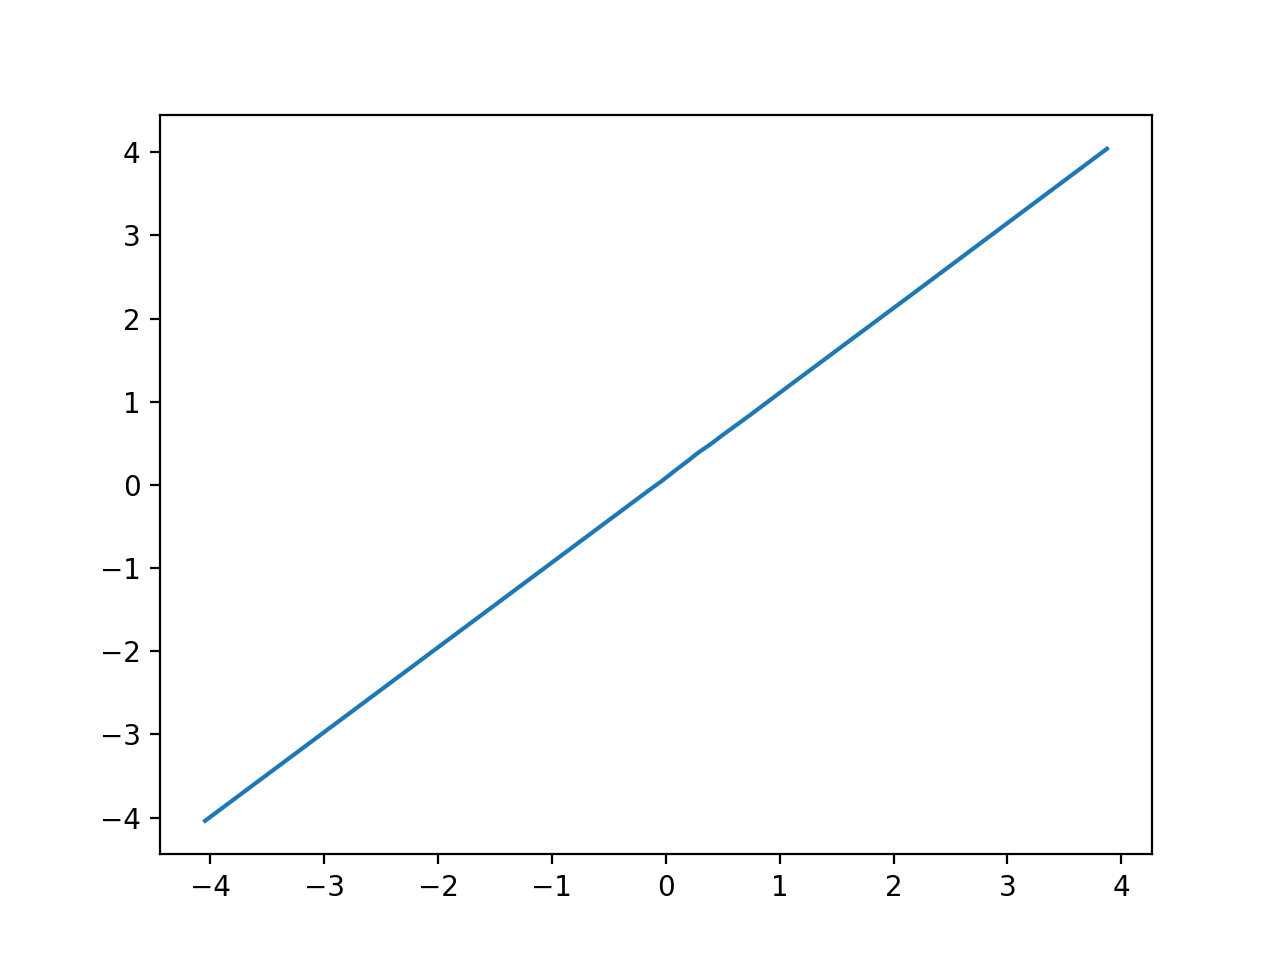

In [13]:
ep_ours.plot_main_effect(0)

<IPython.core.display.Javascript object>


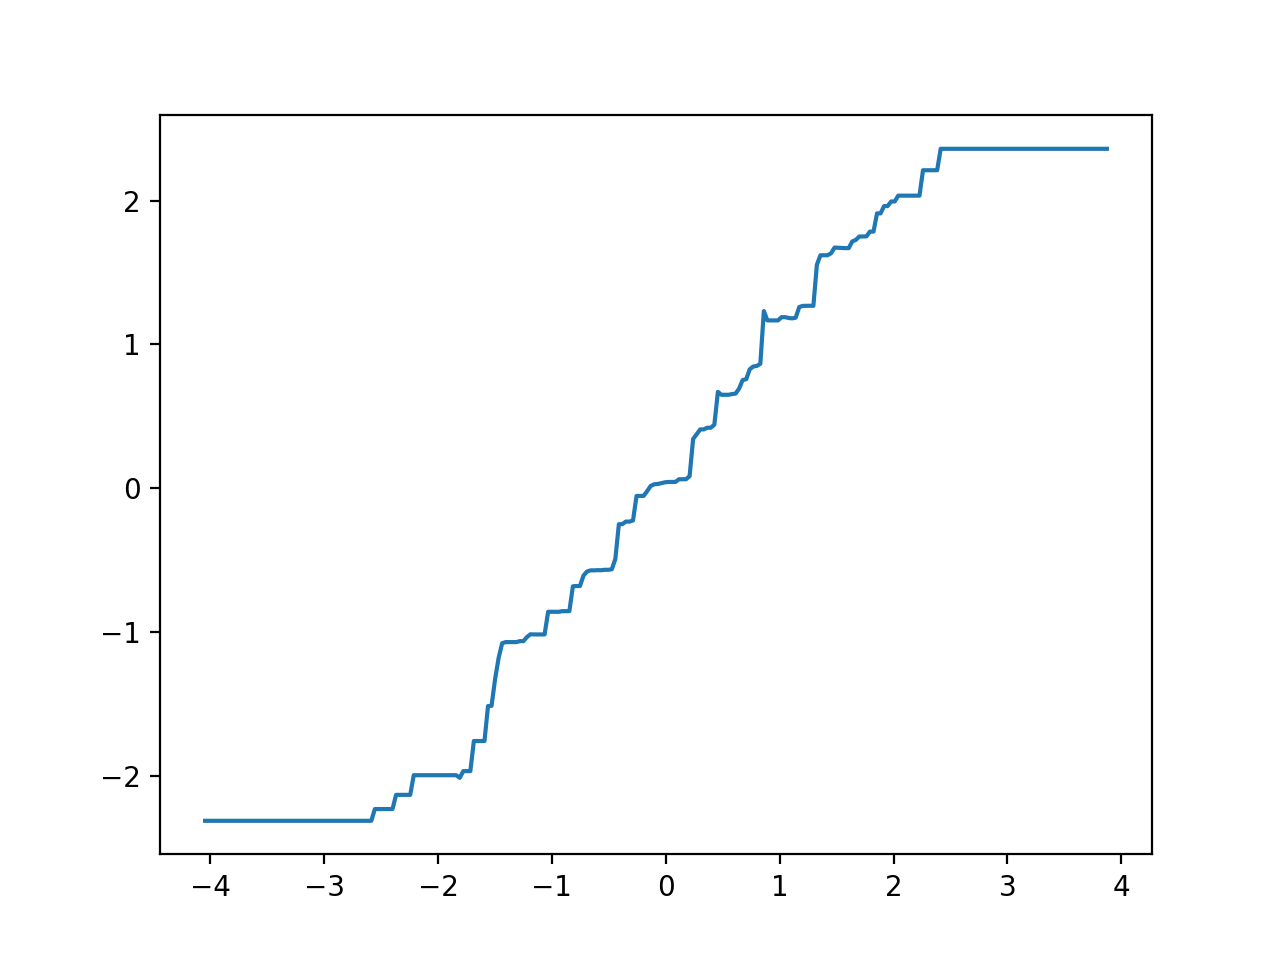

In [14]:
ep_ebm.plot_main_effect(0)

<IPython.core.display.Javascript object>


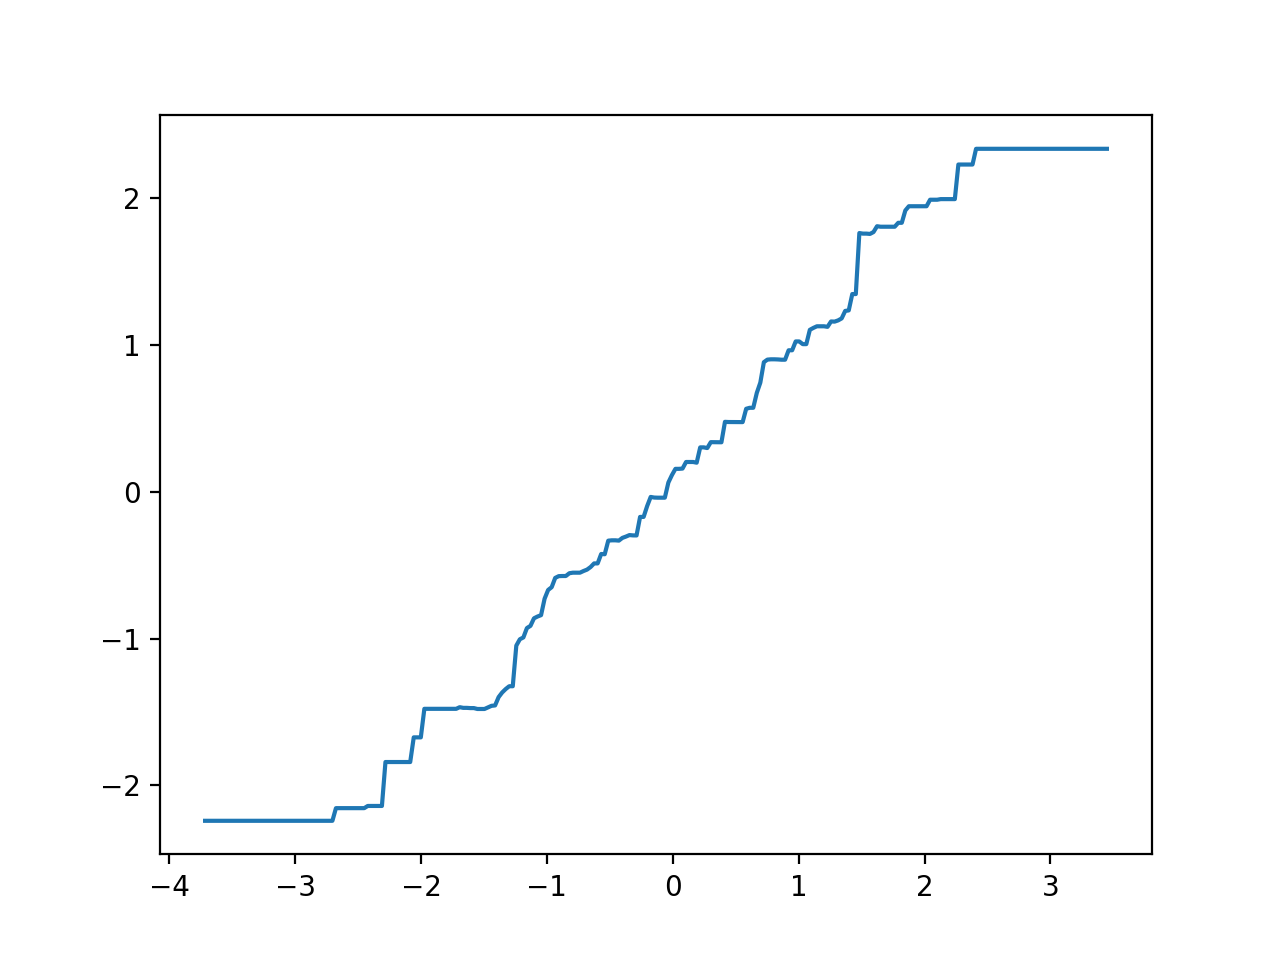

In [25]:
ep_ebm.plot_main_effect(1)

<IPython.core.display.Javascript object>


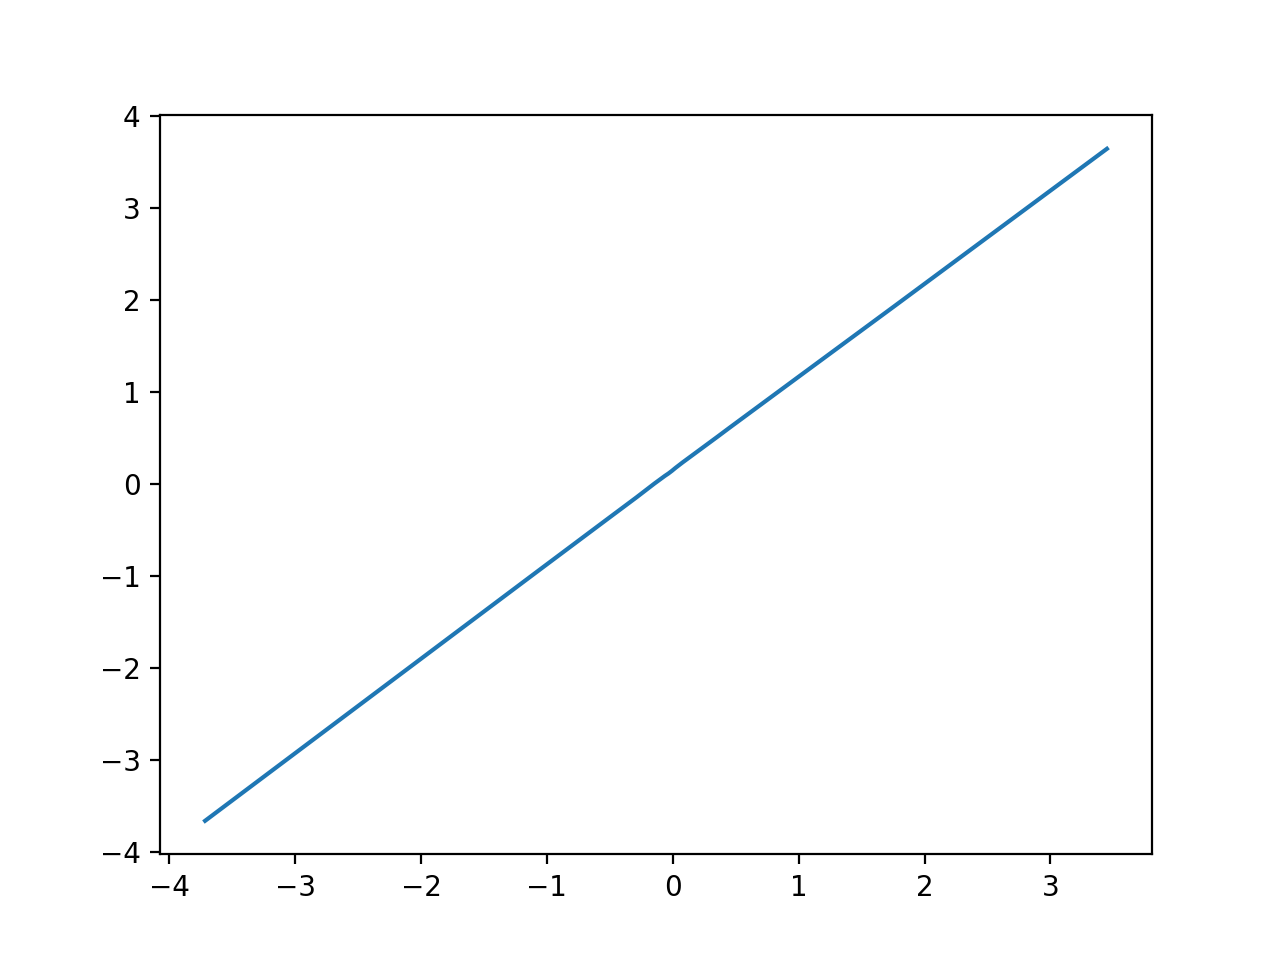

In [26]:
ep_ours.plot_main_effect(1)

<IPython.core.display.Javascript object>


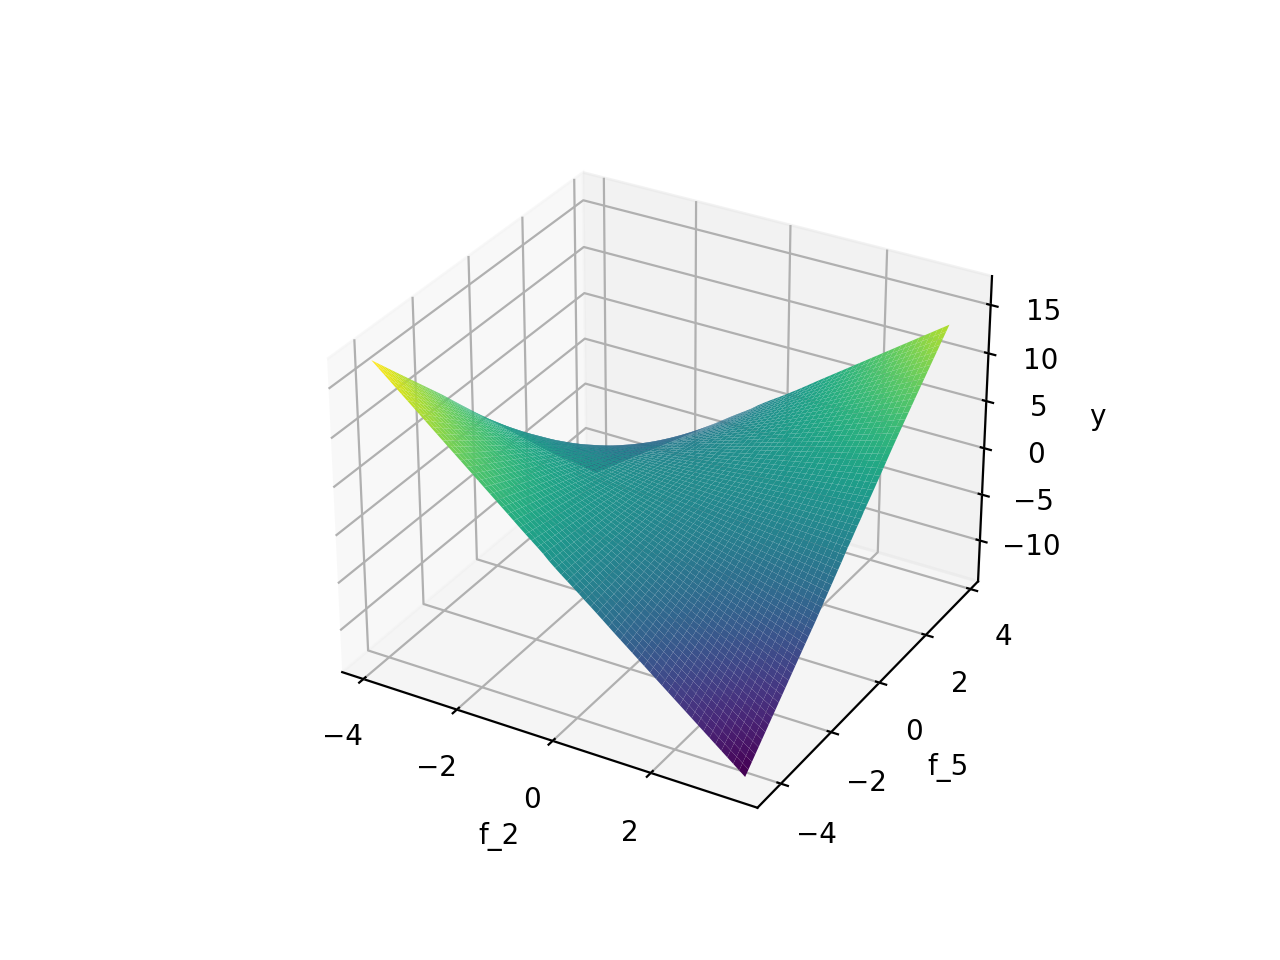

In [18]:
ep_ours.plot_interaction(2,5)

<IPython.core.display.Javascript object>


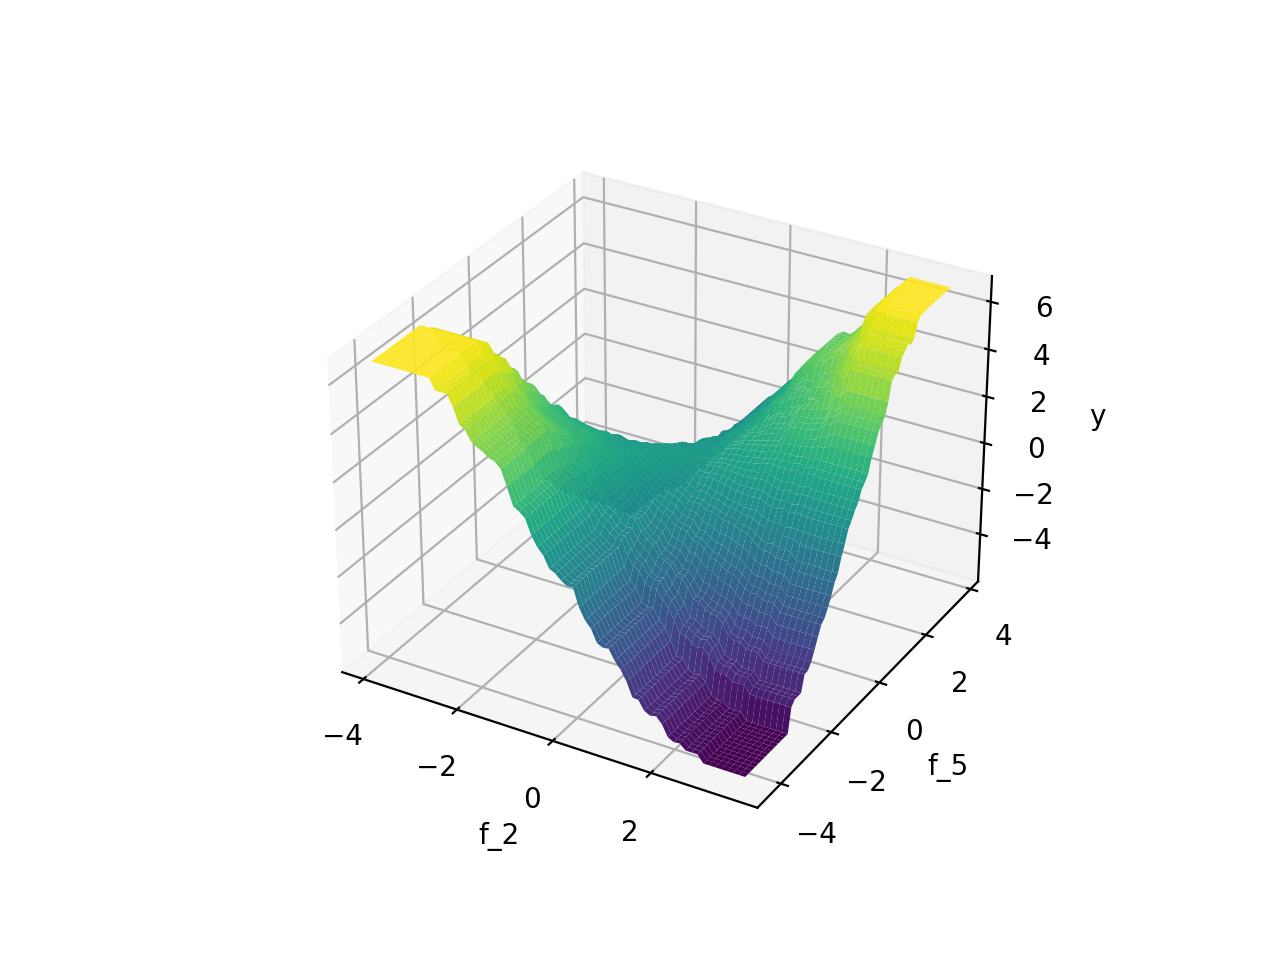

In [19]:
ep_ebm.plot_interaction(2,5)

<IPython.core.display.Javascript object>


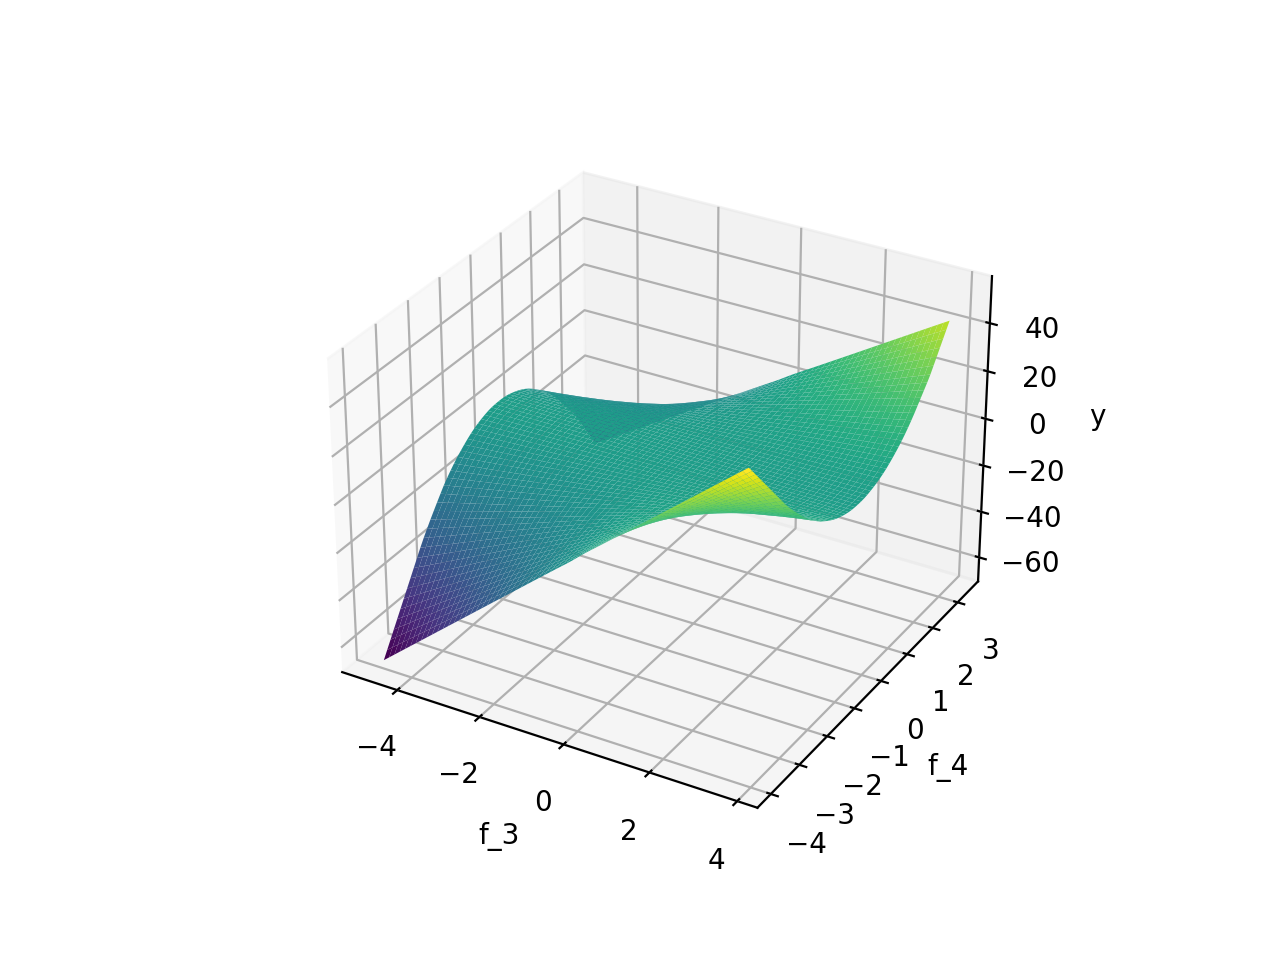

In [20]:
ep_ours.plot_interaction(3,4)

<IPython.core.display.Javascript object>


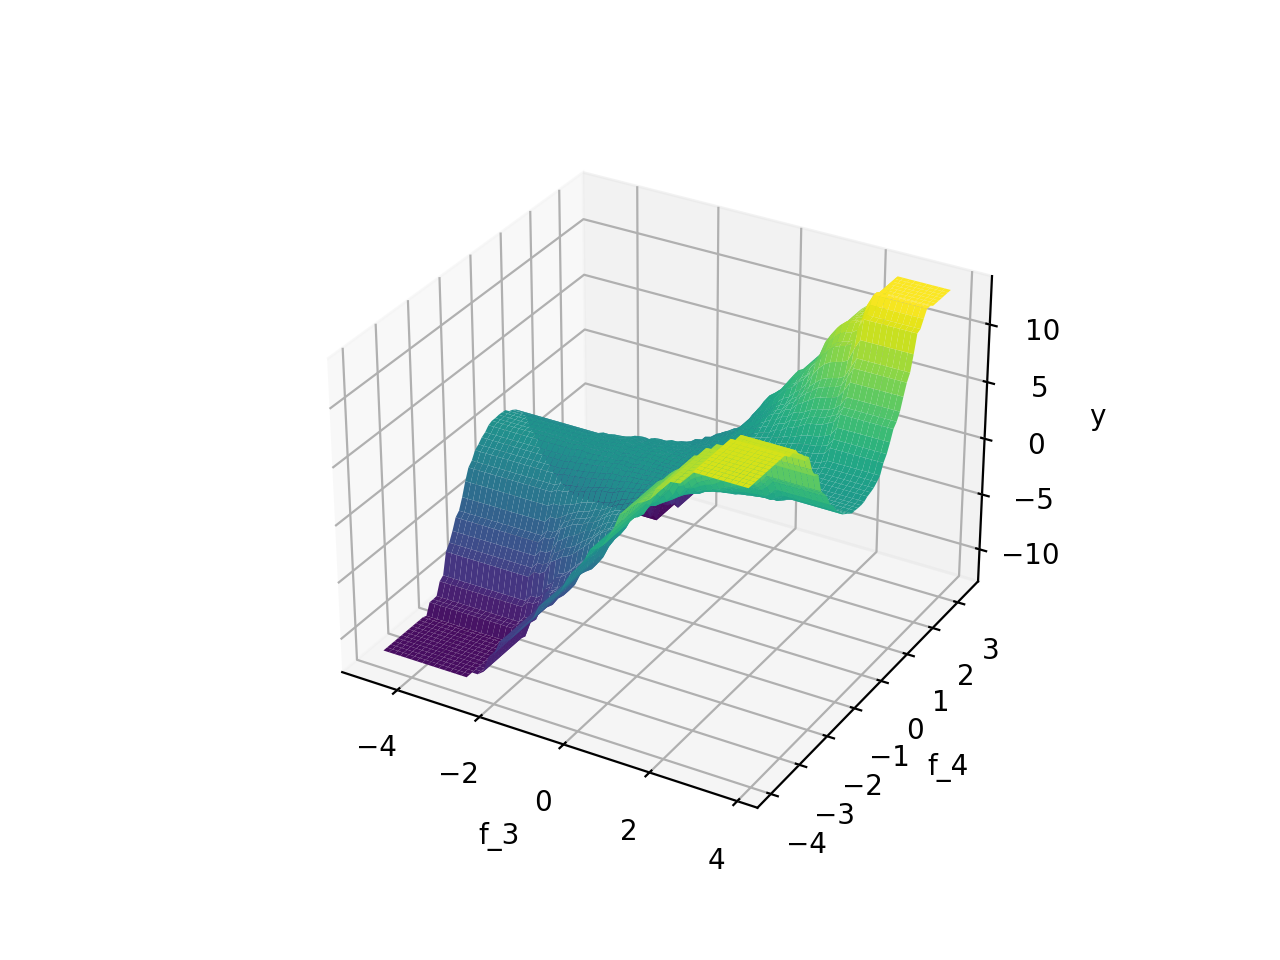

In [21]:
ep_ebm.plot_interaction(3,4)

<IPython.core.display.Javascript object>


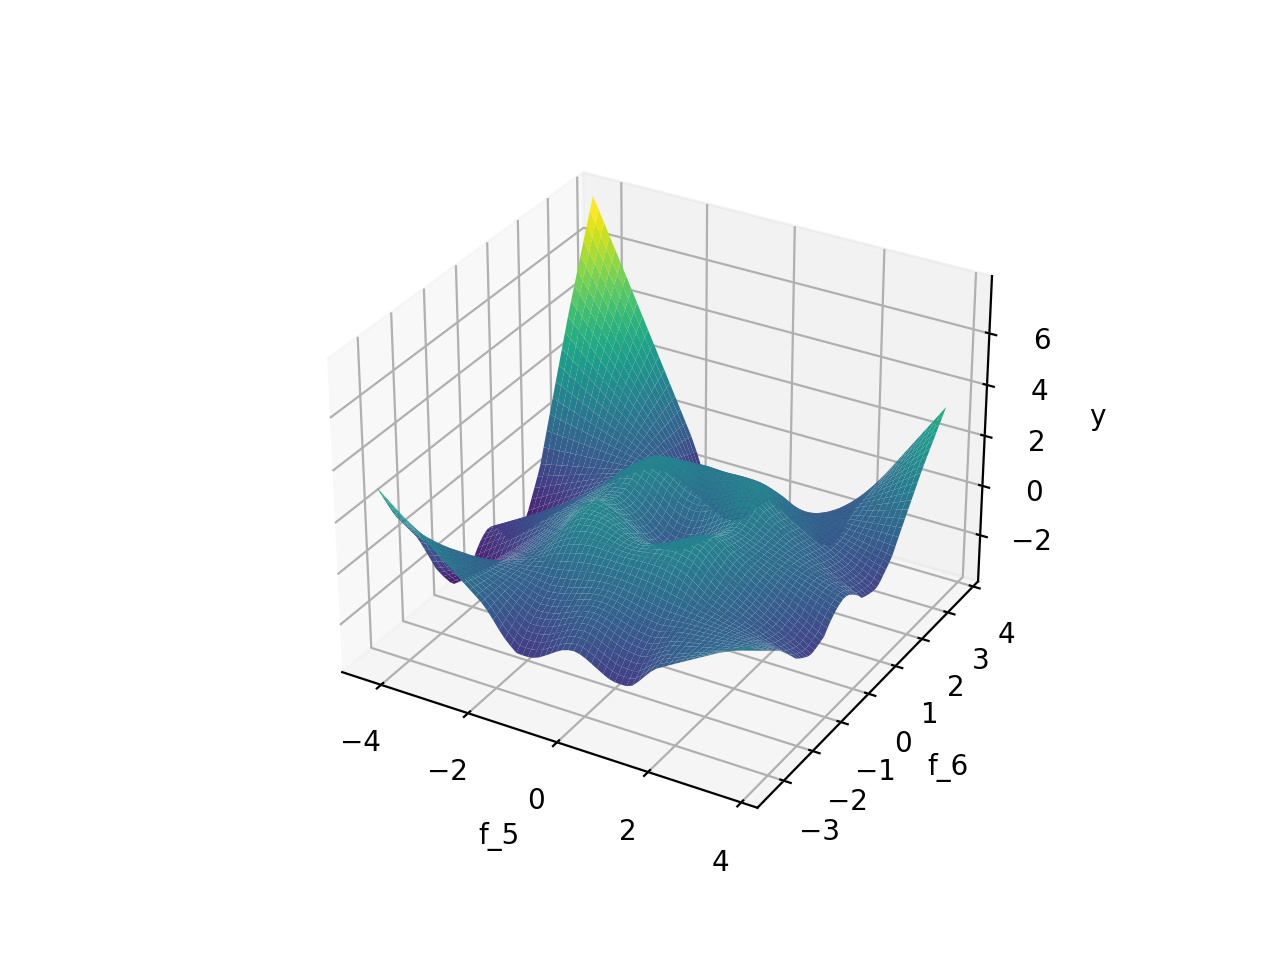

In [33]:
ep_ours.plot_interaction(5,6)

<IPython.core.display.Javascript object>


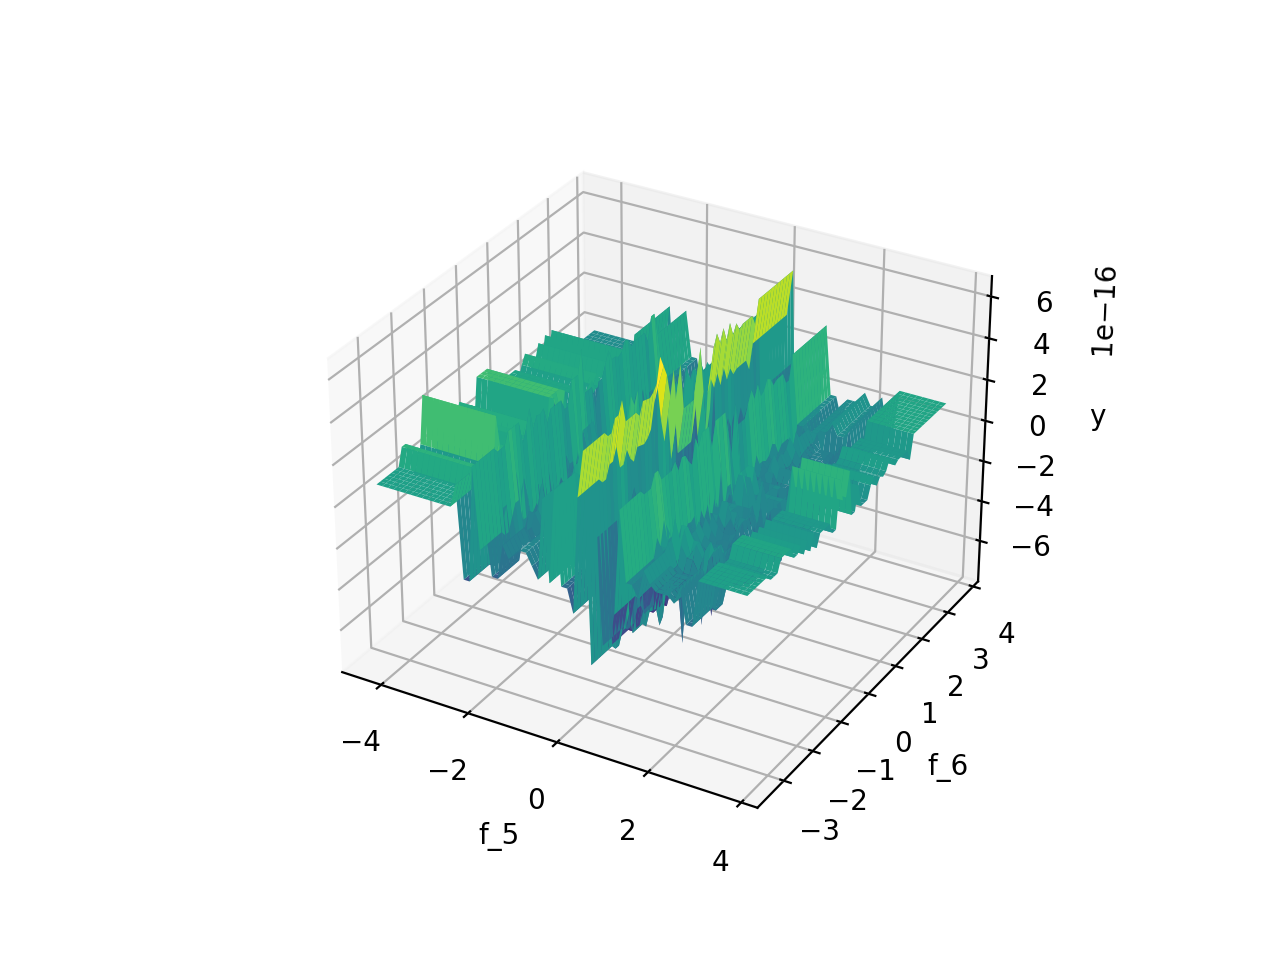

In [34]:
ep_ebm.plot_interaction(5,6)